=== Brazil Season Correlations (Oct–Mar) ===
               ADM_PRICE  BG_PRICE  SOY_PRICE
ONI             0.003463 -0.030910  -0.364398
enso_proxy      0.536099  0.474889   0.201149
la_nina_index  -0.308116 -0.310378  -0.041049
SWI_Brazil      0.477705  0.381901   0.124417
SWI_US         -0.458301 -0.345116  -0.165898
SOY_PRICE       0.653619  0.722221        NaN

=== US Season Correlations (May–Sep) ===
               ADM_PRICE  BG_PRICE  SOY_PRICE
ONI             0.108552  0.159315  -0.042920
enso_proxy      0.763169  0.620155   0.269052
la_nina_index  -0.393576 -0.293176  -0.013533
SWI_Brazil      0.713563  0.598280   0.229577
SWI_US          0.163640  0.020956   0.297083
SOY_PRICE       0.587637  0.664409        NaN
=== Scatter plots – Brazil season (Oct–Mar) ===


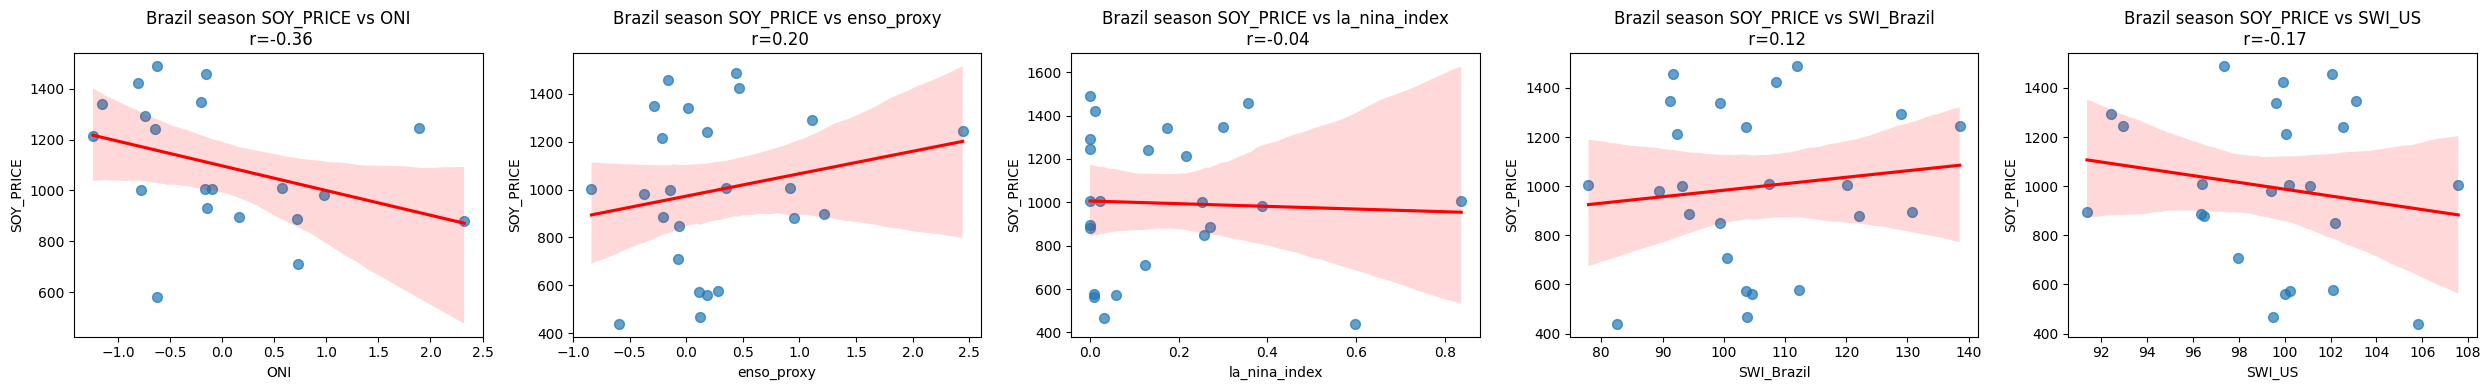

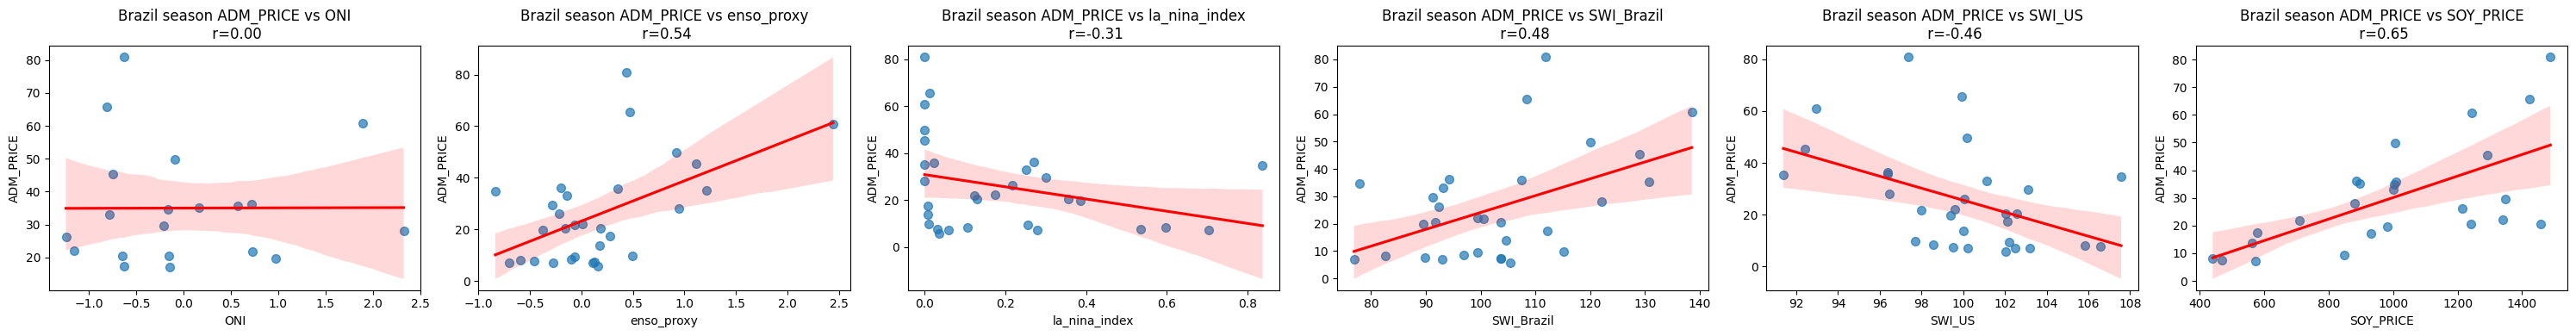

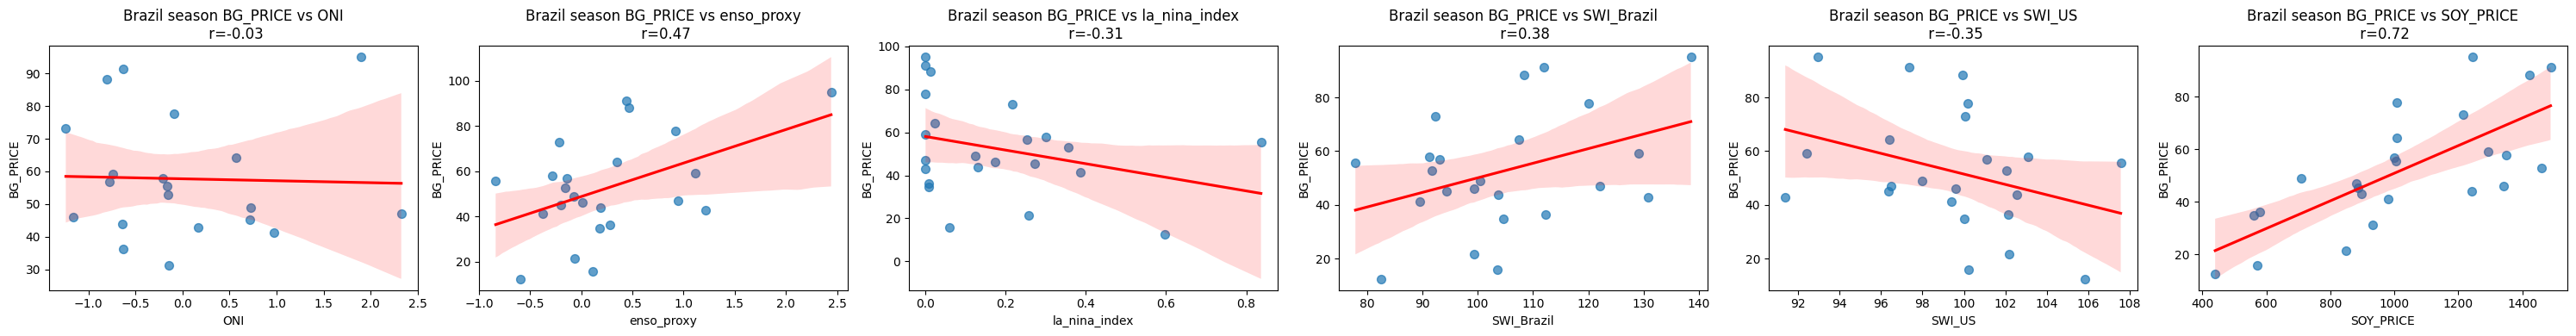

=== Scatter plots – US season (May–Sep) ===


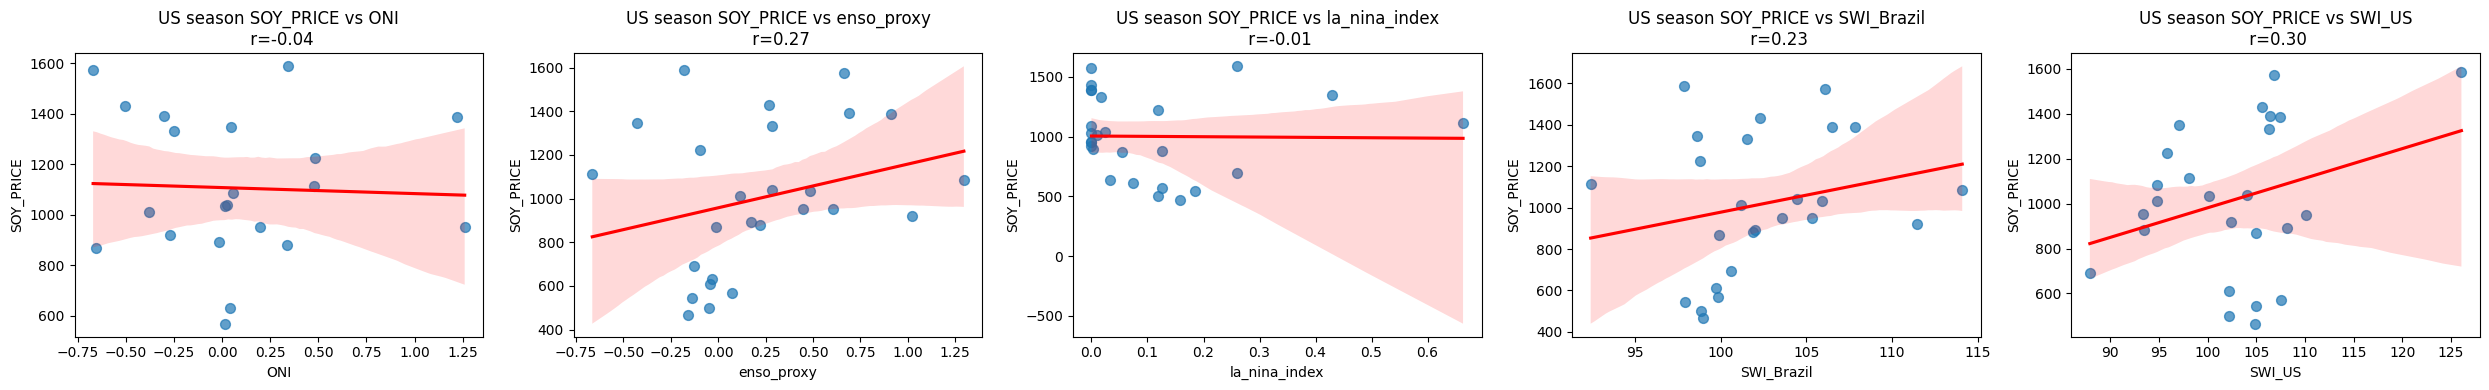

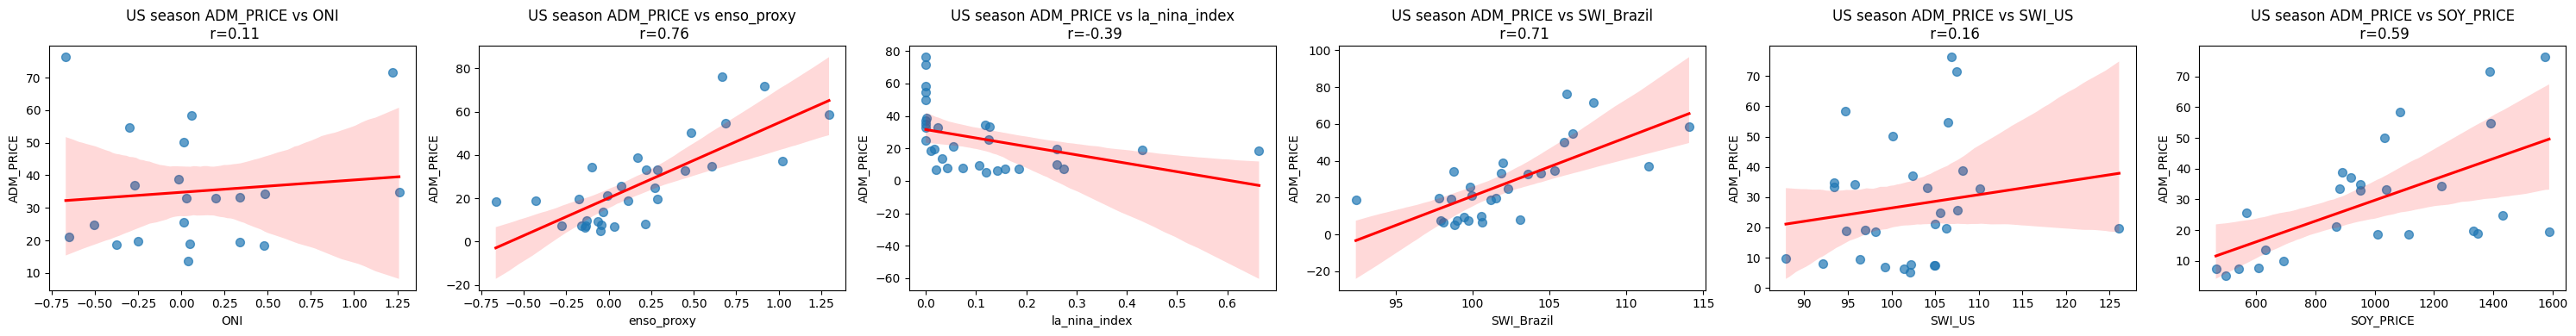

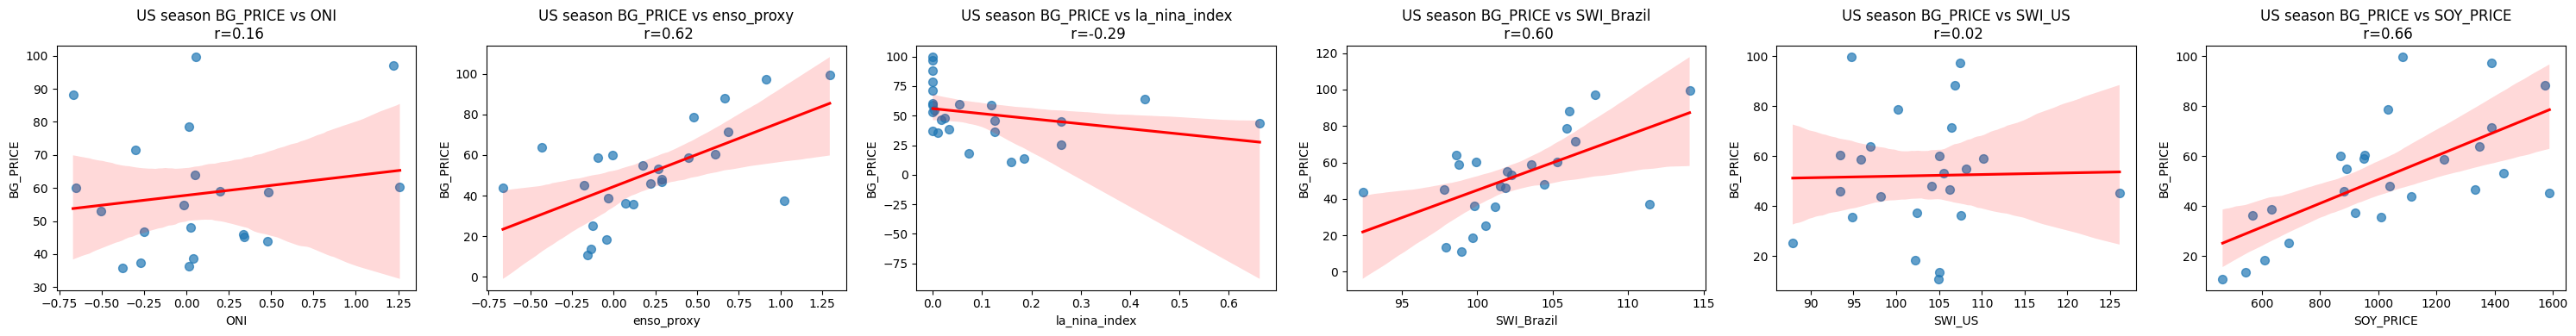

In [10]:
import os
import pandas as pd
import numpy as np

# ====== Load ======
BASE_CSV = "data_out/market_with_enso_proxy_monthly.csv"
ALT_ONI  = "data/soy_simple_monthly.csv"  # źródło ONI jeśli brak w BASE_CSV

df = pd.read_csv(BASE_CSV, parse_dates=["date"]).set_index("date").sort_index()
df.index = df.index.to_period("M").to_timestamp("M")  # ujednolicenie: koniec miesiąca

# --- Dołącz ONI, jeśli go nie ma w df ---
if "ONI" not in df.columns:
    if os.path.exists(ALT_ONI):
        df_oni = pd.read_csv(ALT_ONI, parse_dates=["date"]).set_index("date").sort_index()
        df_oni.index = df_oni.index.to_period("M").to_timestamp("M")
        if "ONI" in df_oni.columns:
            df = df.join(df_oni[["ONI"]], how="left")
        elif "oni" in df_oni.columns:
            df = df.join(df_oni[["oni"]].rename(columns={"oni":"ONI"}), how="left")
    # jeśli dalej brak, trudno — będziemy działać bez ONI

# Keep only relevant columns (+ ONI jeśli jest)
base_cols = ["ADM_PRICE","BG_PRICE","SOY_PRICE",
             "enso_proxy","la_nina_index","SWI_Brazil","SWI_US"]
cols = base_cols + (["ONI"] if "ONI" in df.columns else [])
df = df[cols]

# ====== Define seasons ======
def assign_brazil_season(ts: pd.Timestamp) -> int:
    # Brazil season runs Oct–Mar -> label by harvest year (the Jan year)
    return ts.year + 1 if ts.month >= 10 else ts.year

def assign_us_season(ts: pd.Timestamp) -> int:
    # US season May–Sep -> label by calendar year
    return ts.year

df["Season_BR"] = df.index.map(assign_brazil_season)
df["Season_US"] = df.index.map(assign_us_season)
df["Month"] = df.index.month

# ====== Aggregate to seasonal means ======
# Brazil season: Oct–Mar
df_br = df[df["Month"].isin([10,11,12,1,2,3])]
season_br = df_br.groupby("Season_BR").mean(numeric_only=True)

# US season: May–Sep
df_us = df[df["Month"].isin([5,6,7,8,9])]
season_us = df_us.groupby("Season_US").mean(numeric_only=True)

# ====== Correlation tests ======
def correlation_table(season_df, target, variables):
    out = {}
    for var in variables:
        if var in season_df.columns:
            corr = season_df[[target, var]].dropna().corr().iloc[0,1]
            out[var] = corr
    return pd.Series(out, name=target)

# lista zmiennych do korelacji i wykresów
core_vars = ["enso_proxy","la_nina_index","SWI_Brazil","SWI_US"]
if "ONI" in df.columns:
    core_vars = ["ONI"] + core_vars   # ONI równolegle do enso_proxy

# For ADM and BG (Brazil + US seasons separately)
variables_with_soy = core_vars + ["SOY_PRICE"]

corr_adm_br = correlation_table(season_br, "ADM_PRICE", variables_with_soy)
corr_bg_br  = correlation_table(season_br, "BG_PRICE",  variables_with_soy)
corr_soy_br = correlation_table(season_br, "SOY_PRICE", core_vars)

corr_adm_us = correlation_table(season_us, "ADM_PRICE", variables_with_soy)
corr_bg_us  = correlation_table(season_us, "BG_PRICE",  variables_with_soy)
corr_soy_us = correlation_table(season_us, "SOY_PRICE", core_vars)

# ====== Display ======
print("=== Brazil Season Correlations (Oct–Mar) ===")
print(pd.concat([corr_adm_br, corr_bg_br, corr_soy_br], axis=1))

print("\n=== US Season Correlations (May–Sep) ===")
print(pd.concat([corr_adm_us, corr_bg_us, corr_soy_us], axis=1))


# ====== Scatter plots ======
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_plots(season_df, target, variables, title_prefix=""):
    vars_in = [v for v in variables if v in season_df.columns]
    n = len(vars_in)
    if n == 0:
        print(f"[WARN] No variables found for {target} plots.")
        return
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4), sharey=False)
    if n == 1:
        axes = [axes]
    for ax, var in zip(axes, vars_in):
        x = season_df[var]
        y = season_df[target]
        sns.regplot(x=x, y=y, ax=ax, scatter_kws={"s":50, "alpha":0.7}, line_kws={"color":"red"})
        ax.set_xlabel(var); ax.set_ylabel(target)
        corr = season_df[[target, var]].dropna().corr().iloc[0,1]
        ax.set_title(f"{title_prefix} {target} vs {var}\n r={corr:.2f}")
    plt.tight_layout(); plt.show()

print("=== Scatter plots – Brazil season (Oct–Mar) ===")
scatter_plots(season_br, "SOY_PRICE", core_vars, title_prefix="Brazil season")
scatter_plots(season_br, "ADM_PRICE", core_vars + ["SOY_PRICE"], title_prefix="Brazil season")
scatter_plots(season_br, "BG_PRICE",  core_vars + ["SOY_PRICE"], title_prefix="Brazil season")

print("=== Scatter plots – US season (May–Sep) ===")
scatter_plots(season_us, "SOY_PRICE", core_vars, title_prefix="US season")
scatter_plots(season_us, "ADM_PRICE", core_vars + ["SOY_PRICE"], title_prefix="US season")
scatter_plots(season_us, "BG_PRICE",  core_vars + ["SOY_PRICE"], title_prefix="US season")
